In [24]:
import numpy as np
import pandas as pd
from collections import Counter

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score, recall_score, confusion_matrix, accuracy_score

import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from sklearn.ensemble import VotingClassifier

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from pytorch_tabnet.tab_model import TabNetClassifier

import optuna

import warnings
warnings.filterwarnings('ignore')

In [25]:
class CONFIG:    
    # paths
    METADATA_PATH = 'subject_data.csv'
    IMAGES_PATH = 'images.hdf5'

    # Undersampling and Oversampling
    # Ratio of negative to positive samples
    ## In original training data distribution is:
        ## target
        ## 0    400666
        ## 1       393
        
    NEG_RATIO = 50 #50
    SMOTE = True # ENCODE_CAT must be True
    SMOTE_RATIO = 0.3
    K_NEIGHBORS = 2
    
    # Features to use
    METADATA_FEATURES = True # Initial features
    GROUPBY_FEATURES = True
    IMAGE_FEATURES = False # Add isic_id column if True
    
    # Early stopping rounds
    EARLY_STOP = 30
    
    # Number of KFold splits
    N_SPLITS = 5 
    
    # Testing encode or not cat_cols
    ENCODE_CAT = True
    
    # LightGBM parameters
    lgb_params = {
        'objective': "binary",
        'verbosity': -1,
        'boosting_type': "gbdt",
        'depth': None,
        'n_estimators': 200,
        'learning_rate': 0.05,    
        'lambda_l1': 0.0005, 
        'lambda_l2': 8, 
        'num_leaves': 130, 
        'feature_fraction': 0.5, 
        'bagging_fraction': 1, 
        'bagging_freq': 6,
        'min_child_samples': 60
    }

    # XGBoost parameters
    xgb_params = {
        'verbosity': 0,
        'depth': None,
        'n_estimators': 200,
        'learning_rate': 0.05,    
        'lambda_l1': 0.0005, 
        'lambda_l2': 8, 
        'num_leaves': 130, 
        'feature_fraction': 0.5, 
        'bagging_fraction': 1, 
        'bagging_freq': 6,
        'min_child_samples': 60
    }

    # TabNet model
    tabnet_params = {
        'n_d': 16,
        'n_a': 16,
        'n_steps': 5,
        'gamma': 1.5,
        'lambda_sparse': 1e-4,
        'optimizer_fn': torch.optim.Adam,
        'optimizer_params': dict(lr=2e-2),
        'mask_type': 'sparsemax',
        'verbose': 10
    }

In [33]:
class Processing:    
    def __init__(self):
        pass
    def filter_data(self, path):
        """
        Reads CSV into pandas DataFrame and drops redundant columns.
        """
        df = pd.read_csv(path, low_memory=False)

        drop_cols = [
            'isic_id',  # Redundant for loading train data
            'image_type',  # Only one unique value in train metadata
            'tbp_lv_location_simple',  # Similar to 'tbp_lv_location'
            'copyright_license',  # Not useful for lesion classification

            # Predictive Features
            'lesion_id',
            'iddx_full',
            'iddx_1', 
            'iddx_2', 
            'iddx_3',
            'iddx_4', 
            'iddx_5', 
            'mel_mitotic_index', 
            'mel_thick_mm',
        ]

        # Drop only columns that exist
        df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')
        
        return df

    def set_datatypes(self, df: pd.DataFrame):
        """
        Converts column dtypes: handle NAs, cast numeric & categorical columns.
        """
        # Handle NA values in 'age_approx'
        if 'age_approx' in df.columns:
            df['age_approx'] = df['age_approx'].replace('NA', -1)

        # Integer columns
        int_cols = ['target', 'age_approx', 'tbp_lv_symm_2axis_angle']
        for col in int_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int16')

        # Float columns
        float_cols = [
            'clin_size_long_diam_mm',
            'tbp_lv_A', 
            'tbp_lv_Aext', 
            'tbp_lv_B', 
            'tbp_lv_Bext',
            'tbp_lv_C', 
            'tbp_lv_Cext', 
            'tbp_lv_H', 
            'tbp_lv_Hext', 
            'tbp_lv_L', 
            'tbp_lv_Lext',
            'tbp_lv_areaMM2', 
            'tbp_lv_area_perim_ratio', 
            'tbp_lv_color_std_mean',
            'tbp_lv_deltaA', 
            'tbp_lv_deltaB', 
            'tbp_lv_deltaL', 
            'tbp_lv_deltaLB',
            'tbp_lv_deltaLBnorm', 
            'tbp_lv_eccentricity', 
            'tbp_lv_minorAxisMM',
            'tbp_lv_nevi_confidence', 
            'tbp_lv_norm_border', 
            'tbp_lv_norm_color',
            'tbp_lv_perimeterMM', 
            'tbp_lv_radial_color_std_max', 
            'tbp_lv_stdL', 
            'tbp_lv_stdLExt',
            'tbp_lv_symm_2axis', 
            'tbp_lv_x', 
            'tbp_lv_y', 
            'tbp_lv_z'
        ]
        for col in float_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce').astype('float32')

        # Categorical columns
        cat_cols = [
            'sex', 
            'anatom_site_general', 
            'tbp_tile_type', 
            'tbp_lv_location', 
            'attribution'
        ]
        for col in cat_cols:
            if col in df.columns:
                df[col] = df[col].astype('category')

        return df

    def initial_processing(self, df: pd.DataFrame):
        """
        Applies full processing pipeline to the DataFrame.
        """
        df = self.filter_data(df)
        df = self.set_datatypes(df)
        return df


In [34]:
class FeatureEngineering:    
    def __init__(self):
        pass
    
    def feature_engineering(self, df):        
        # Malignant v/s Benign Predictive Features from Perplexity Suggestions
        
        df["lesion_size_ratio"] = df["tbp_lv_minorAxisMM"] / df["clin_size_long_diam_mm"]
        df["lesion_shape_index"] = df["tbp_lv_areaMM2"] / (df["tbp_lv_perimeterMM"] ** 2)
        df["hue_contrast"] = (df["tbp_lv_H"] - df["tbp_lv_Hext"]).abs()
        df["luminance_contrast"] = (df["tbp_lv_L"] - df["tbp_lv_Lext"]).abs()
        df["lesion_color_difference"] = np.sqrt(df["tbp_lv_deltaA"]**2 + df["tbp_lv_deltaB"]**2 + df["tbp_lv_deltaL"]**2)
        df["border_complexity"] = df["tbp_lv_norm_border"] + df["tbp_lv_symm_2axis"]
        df["3d_position_distance"] = np.sqrt(df["tbp_lv_x"]**2 + df["tbp_lv_y"]**2 + df["tbp_lv_z"]**2)
        df["perimeter_to_area_ratio"] = df["tbp_lv_perimeterMM"] / df["tbp_lv_areaMM2"]
        df["lesion_visibility_score"] = df["tbp_lv_deltaLBnorm"] + df["tbp_lv_norm_color"]
        df["symmetry_border_consistency"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_norm_border"]
        df["color_consistency"] = df["tbp_lv_stdL"] / df["tbp_lv_Lext"]
        df["size_age_interaction"] = df["clin_size_long_diam_mm"] * df["age_approx"]
        df["hue_color_std_interaction"] = df["tbp_lv_H"] * df["tbp_lv_color_std_mean"]
        df["lesion_severity_index"] = (df["tbp_lv_norm_border"] + df["tbp_lv_norm_color"] + df["tbp_lv_eccentricity"]) / 3
        df["color_contrast_index"] = df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"] + df["tbp_lv_deltaLBnorm"]
        df["log_lesion_area"] = np.log(df["tbp_lv_areaMM2"] + 1)
        df["normalized_lesion_size"] = df["clin_size_long_diam_mm"] / df["age_approx"]
        df["mean_hue_difference"] = (df["tbp_lv_H"] + df["tbp_lv_Hext"]) / 2
        df["std_dev_contrast"] = np.sqrt((df["tbp_lv_deltaA"]**2 + df["tbp_lv_deltaB"]**2 + df["tbp_lv_deltaL"]**2) / 3)
        df["color_shape_composite_index"] = (df["tbp_lv_color_std_mean"] + df["tbp_lv_area_perim_ratio"] + df["tbp_lv_symm_2axis"]) / 3
        df["overall_color_difference"] = (df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"]) / 3
        df["symmetry_perimeter_interaction"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_perimeterMM"]
        df["comprehensive_lesion_index"] = (df["tbp_lv_area_perim_ratio"] + df["tbp_lv_eccentricity"] + df["tbp_lv_norm_color"] + df["tbp_lv_symm_2axis"]) / 4
        
        # Handling error indicators
        df["color_uniformity"] = df["tbp_lv_color_std_mean"] / df["tbp_lv_radial_color_std_max"]
        df["color_uniformity"] = df["color_uniformity"].replace([np.nan, np.inf, -np.inf], 0)
        
        df["combined_anatomical_site"] = (df["anatom_site_general"].astype(str) + "_" + df["tbp_lv_location"].astype(str)).astype("category")
        df["shape_complexity_index"] = df["border_complexity"] + df["lesion_shape_index"]
        df["3d_lesion_orientation"] = np.arctan2(df["tbp_lv_y"], df["tbp_lv_x"])        
        df["color_variance_ratio"] = df["tbp_lv_color_std_mean"] / df["tbp_lv_stdLExt"]
        df["border_color_interaction"] = df["tbp_lv_norm_border"] * df["tbp_lv_norm_color"]
        df["size_color_contrast_ratio"] = df["clin_size_long_diam_mm"] / df["tbp_lv_deltaLBnorm"]
        df["age_normalized_nevi_confidence"] = df["tbp_lv_nevi_confidence"] / df["age_approx"]
        df["color_asymmetry_index"] = df["tbp_lv_radial_color_std_max"] * df["tbp_lv_symm_2axis"]
        df["3d_volume_approximation"] = df["tbp_lv_areaMM2"] * np.sqrt(df["tbp_lv_x"]**2 + df["tbp_lv_y"]**2 + df["tbp_lv_z"]**2)
        df["color_range"] = (df["tbp_lv_L"] - df["tbp_lv_Lext"]).abs() + (df["tbp_lv_A"] - df["tbp_lv_Aext"]).abs() + (df["tbp_lv_B"] - df["tbp_lv_Bext"]).abs()
        df["shape_color_consistency"] = df["tbp_lv_eccentricity"] * df["tbp_lv_color_std_mean"]
        df["border_length_ratio"] = df["tbp_lv_perimeterMM"] / (2 * np.pi * np.sqrt(df["tbp_lv_areaMM2"] / np.pi))
        df["age_size_symmetry_index"] = df["age_approx"] * df["clin_size_long_diam_mm"] * df["tbp_lv_symm_2axis"]
        
        return df
    
    def grouped_feature_engineering(self, df):
        # 1. Ratios within age_approx groups
        df['tbp_lv_ratio_A'] = (
            df['tbp_lv_A'] / (df['tbp_lv_Aext'] * df.groupby('age_approx')['tbp_lv_A'].transform('min'))
        ).astype('float32')

        df['tbp_lv_ratio_B'] = (
            df['tbp_lv_B'] / (df['tbp_lv_Bext'] * df.groupby('age_approx')['tbp_lv_B'].transform('min'))
        ).astype('float32')

        df['tbp_lv_ratio_C'] = (
            df['tbp_lv_C'] / (df['tbp_lv_Cext'] * df.groupby('age_approx')['tbp_lv_C'].transform('min'))
        ).astype('float32')

        df['tbp_lv_ratio_H'] = (
            df['tbp_lv_H'] / (df['tbp_lv_Hext'] * df.groupby('age_approx')['tbp_lv_H'].transform('min'))
        ).astype('float32')

        df['tbp_lv_ratio_L'] = (
            df['tbp_lv_L'] / (df['tbp_lv_Lext'] * df.groupby('age_approx')['tbp_lv_L'].transform('min'))
        ).astype('float32')

        # 2. Contrast
        df['tbp_lv_contrast_A'] = (df['tbp_lv_A'] - df['tbp_lv_Aext']).astype('float32')
        df['tbp_lv_contrast_B'] = (df['tbp_lv_B'] - df['tbp_lv_Bext']).astype('float32')
        df['tbp_lv_contrast_C'] = (df['tbp_lv_C'] - df['tbp_lv_Cext']).astype('float32')
        df['tbp_lv_contrast_H'] = (df['tbp_lv_H'] - df['tbp_lv_Hext']).astype('float32')
        df['tbp_lv_contrast_L'] = (df['tbp_lv_L'] - df['tbp_lv_Lext']).astype('float32')

        # 3. Patient-level ratios
        for col in ['tbp_lv_ratio_A', 'tbp_lv_ratio_B', 'tbp_lv_ratio_C', 'tbp_lv_ratio_H', 'tbp_lv_ratio_L']:
            df[f'tbp_lv_patient_{col.split("_", 2)[-1]}'] = (
                df[col] / df.groupby('patient_id')[col].transform('mean')
            ).astype('float32')

        # 4. Patient-level contrasts
        for col in ['tbp_lv_contrast_A', 'tbp_lv_contrast_B', 'tbp_lv_contrast_C', 'tbp_lv_contrast_H', 'tbp_lv_contrast_L']:
            df[f'tbp_lv_patient_{col.split("_", 2)[-1]}'] = (
                df[col] / df.groupby('patient_id')[col].transform('mean')
            ).astype('float32')

        # 5. Age-level ratios
        for col in ['tbp_lv_ratio_A', 'tbp_lv_ratio_B', 'tbp_lv_ratio_C', 'tbp_lv_ratio_H', 'tbp_lv_ratio_L']:
            df[f'tbp_lv_age_{col.split("_", 2)[-1]}'] = (
                df[col] / df.groupby('age_approx')[col].transform('mean')
            ).astype('float32')

        # 6. Age-level contrasts
        for col in ['tbp_lv_contrast_A', 'tbp_lv_contrast_B', 'tbp_lv_contrast_C', 'tbp_lv_contrast_H', 'tbp_lv_contrast_L']:
            df[f'tbp_lv_age_{col.split("_", 2)[-1]}'] = (
                df[col] / df.groupby('age_approx')[col].transform('mean')
            ).astype('float32')

        return df

    
    def add_image_features(self, file_path):
        img_df = pd.read_csv(file_path)
        if "isic_id" in img_df.columns:
            img_df = img_df.drop(columns=["isic_id"])
        return img_df
    
    def extract_cat_cols(self, df):
        return df.select_dtypes(include=["category"]).columns.tolist()
    
    def downsample_data(self, df, neg_ratio=None, is_train=True):
        if is_train:
            p_cases = df[df["target"] == 1]
            n_cases = df[df["target"] == 0]
            if neg_ratio is not None:
                N = int(len(p_cases) * neg_ratio)
                n_cases = n_cases.sample(n=N, random_state=23)
            df = pd.concat([n_cases, p_cases], ignore_index=True)
        return df
    
    def remove_null_features(self, df, is_train=True):
        if is_train:
            df = df.dropna(how='any')
        return df

    def process_data(self, df, neg_ratio=None, is_train=True, img_feat_path=None):
        if CONFIG.METADATA_FEATURES:
            df = self.feature_engineering(df)        
        if CONFIG.GROUPBY_FEATURES:
            df = self.grouped_feature_engineering(df)    
        if CONFIG.IMAGE_FEATURES:
            df = self.add_image_features(img_feat_path)        
        cat_cols = self.extract_cat_cols(df)        
        if not CONFIG.IMAGE_FEATURES:
            df = self.downsample_data(df, neg_ratio, is_train)

        if is_train:
            df = self.remove_null_features(df, is_train)
        
        return df, cat_cols

In [82]:
p = Processing()
df = p.initial_processing(CONFIG.METADATA_PATH)

In [83]:
df['target'].value_counts()

target
0    400666
1       393
Name: count, dtype: Int64

In [84]:
fe = FeatureEngineering()
data, cat_cols = fe.process_data(df.copy(), CONFIG.NEG_RATIO, img_feat_path=CONFIG.IMAGES_PATH)

def print_df_info(df):
    # Count the number of columns by data type
    int_cols = df.select_dtypes(include=['int']).shape[1]
    float_cols = df.select_dtypes(include=['float']).shape[1]
    cat_cols = df.select_dtypes(include=['category']).shape[1]
    obj_cols = df.select_dtypes(include=['object']).shape[1]

    # Calculate the total number of nulls in the DataFrame
    total_nulls = df.isnull().sum().sum()
    shape = df.shape
    
    # Print the results
    print(f"Shape: {shape}")
    print(f"Number of integer columns: {int_cols}")
    print(f"Number of float columns: {float_cols}")
    print(f"Number of categorical columns: {cat_cols}")
    print(f"Number of object columns: {obj_cols}")
    print(f"Total number of nulls in the DataFrame: {total_nulls}")


print("\nFINAL DATASET INFORMATION:")
print_df_info(data)

# Final categorical columns
print(f"\nFinal categorical columns: \n{cat_cols}")


FINAL DATASET INFORMATION:
Shape: (19030, 109)
Number of integer columns: 0
Number of float columns: 99
Number of categorical columns: 6
Number of object columns: 1
Total number of nulls in the DataFrame: 0

Final categorical columns: 
['sex', 'anatom_site_general', 'tbp_tile_type', 'tbp_lv_location', 'attribution', 'combined_anatomical_site']


In [85]:
num_cols = data.select_dtypes(['number']).columns
num_cols = num_cols[1:] # excluding 'target' column
scaler = StandardScaler() # Z-Scaling features
data[num_cols] = scaler.fit_transform(data[num_cols])
data[num_cols]

,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,...,tbp_lv_age_ratio_A,tbp_lv_age_ratio_B,tbp_lv_age_ratio_C,tbp_lv_age_ratio_H,tbp_lv_age_ratio_L,tbp_lv_age_contrast_A,tbp_lv_age_contrast_B,tbp_lv_age_contrast_C,tbp_lv_age_contrast_H,tbp_lv_age_contrast_L
0,1.243606,-0.100039,0.781787,1.901507,-0.572161,0.019702,-0.089553,0.779579,-1.270117,-1.714984,...,-1.052154,-1.034448,-1.292997,0.397350,-0.677492,-1.262306,-2.066706,-1.737805,-0.589995,0.451596
1,-0.216008,3.040342,0.639352,0.612006,-0.314999,-0.265541,0.020901,-0.003891,-0.878883,-0.809827,...,-0.242773,-0.260195,-0.040549,-0.264462,0.012420,0.100548,-0.221579,-0.024497,0.084260,0.515178
2,-2.040526,-0.144348,-1.120523,-0.813640,-1.853328,-1.896887,-1.874503,-1.850486,-0.799620,-0.719828,...,-0.674942,-0.558272,-0.555562,0.060420,0.019373,-0.804103,-0.504319,-0.758010,-0.194606,-1.302287
3,0.513799,3.056957,-0.896086,-0.341678,-1.976057,-1.263195,-1.853994,-1.166660,-1.267365,-0.665592,...,-0.658133,-2.426898,-1.977528,-1.151828,-3.540271,-0.885574,-2.008445,-1.959741,0.977343,4.682795
4,0.878702,-0.753593,-0.301943,0.689301,0.025826,0.108463,-0.131931,0.317644,0.341180,-0.594659,...,-1.091516,-0.057567,-0.799372,1.302344,0.669620,-1.362797,-0.072026,-0.842768,-1.351153,-1.269032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20038,-0.580912,2.325864,-0.639393,-1.002371,-0.793558,-0.466514,-0.891116,-0.756467,-0.084248,0.777280,...,0.652382,-1.050440,-0.574232,-1.156930,-0.588853,0.347832,-0.780729,-0.614112,1.258421,0.087395
20039,0.148895,0.935678,0.508491,-0.235638,1.181675,1.576476,1.078110,1.206756,0.495405,1.135076,...,0.892264,-0.435458,-0.167400,-0.803593,1.211860,1.073282,-0.334872,0.070803,1.014452,-0.997257
20040,0.148895,2.519715,-0.230711,-0.867923,-1.207845,-0.733012,-1.008859,-0.935463,-1.004578,0.423217,...,1.091722,-1.484464,-0.350988,-2.109608,-0.312509,0.795889,-1.150024,-0.527351,2.169080,1.178810
20041,0.513799,4.496991,0.873258,0.974768,-2.044711,-1.380918,-0.953752,-0.656585,-3.195681,-2.201133,...,-0.276345,-2.381744,-0.767713,-2.375442,-0.954453,0.089209,-1.937519,-0.873042,1.537911,1.338366


In [86]:
if CONFIG.ENCODE_CAT:    
    category_encoder = OrdinalEncoder(
        categories='auto', dtype=np.int16, 
        handle_unknown='use_encoded_value', 
        unknown_value=-2, encoded_missing_value=-1
    )

    data_encoded = category_encoder.fit_transform(data[cat_cols])
    # Assign the transformed categories back to the DataFrame
    for c, cat_col in enumerate(cat_cols):
        data[cat_col] = data_encoded[:, c]

In [87]:
def comp_score(solution, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float = 0.80):
    """
    Compute the competition-specific partial AUC score
    Returns:
        float: Partial AUC score scaled to the competition's range.
    """
    # Ensure correct dtype
    if not isinstance(solution, np.ndarray):
        solution = solution.values
    v_gt = abs(np.asarray(solution, dtype=np.int32) - 1)
    v_pred = 1.0 - np.asarray(submission.values, dtype=np.float64)

    max_fpr = abs(1 - min_tpr)

    # scikit-learn partial AUC
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)

    # Scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
    partial_auc = (
        0.5 * max_fpr**2
        + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    )
    return partial_auc


def recall_metric(y_true: np.ndarray, y_pred: np.ndarray, threshold: float = 0.5) -> float:
    """
    Compute recall score from probabilities using sklearn.

    Returns:
        float: Recall score.
    """
    y_pred_binary = (y_pred >= threshold).astype(int)
    return recall_score(y_true, y_pred_binary)


def plot_cm(y_true: np.ndarray, y_pred: np.ndarray, threshold: float = 0.5):
    """
    Plot confusion matrix using sklearn & seaborn.

    Returns:
        matplotlib.figure.Figure: The confusion matrix plot.
    """
    y_pred_binary = (y_pred >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred_binary)
    labels = sorted(np.unique(y_true))

    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='RdYlBu',
        xticklabels=labels,
        yticklabels=labels,
        cbar=True,
        square=True,
        annot_kws={"size": 16},
        ax=ax
    )
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title('Confusion Matrix')
    plt.show()
    plt.close(fig)
    return fig


In [88]:
def smote_oversample(X, y, sampling_strategy=CONFIG.SMOTE_RATIO, k_neighbors=CONFIG.K_NEIGHBORS, random_state=42):  
    X = X.astype(np.float32)
    y = y.astype(np.int16)  
    smote = SMOTE(sampling_strategy=sampling_strategy, k_neighbors=k_neighbors, random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    return X_resampled, y_resampled

In [89]:
def split_data(df):
    v1, v2 = int(df[df['target'] == 0].shape[0]*0.6), int(df[df['target'] == 1].shape[0]*0.4)
    train = pd.concat(
        [
            df[df['target'] == 0].iloc[:v1],
            df[df['target'] == 1].iloc[:v2]
        ]
    )
    test = pd.concat(
        [
            df[df['target'] == 0].iloc[v1:],
            df[df['target'] == 1].iloc[v2:]
        ]
    )

    return train.sample(frac=1, random_state=42), test.sample(frac=1, random_state=42)

In [90]:
train_data, test_data = split_data(data)

In [91]:
gkf = GroupKFold(n_splits=CONFIG.N_SPLITS)

train_data.reset_index(drop=True, inplace=True)

X = train_data.drop(["target", "patient_id"], axis=1)
y = train_data["target"]
groups = train_data["patient_id"]

# Store scores
ensemble_scores = []
ensemble_recalls = []
ensemble_models = []

for fold, (train_index, valid_index) in enumerate(gkf.split(X, y, groups)):

    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    # SMOTE if needed
    if CONFIG.SMOTE:
        X_train, y_train = smote_oversample(X_train, y_train)

    # LightGBM model
    lgb_model = lgb.LGBMClassifier(**CONFIG.lgb_params)

    # XGBoost model
    xgb_model = xgb.XGBClassifier(
        **CONFIG.xgb_params,
        eval_metric="auc",
    )

    # Voting ensemble (soft voting = average of probabilities)
    ensemble = VotingClassifier(
        estimators=[('lgb', lgb_model), ('xgb', xgb_model)],
        voting='soft',
        n_jobs=-1
    )

    # Fit
    ensemble.fit(X_train, y_train)

    # Predictions (probabilities for comp_score)
    preds = ensemble.predict_proba(X_valid)[:, 1]

    # Metrics
    score = comp_score(y_valid, pd.DataFrame(preds, columns=["prediction"]), "")
    recall = recall_metric(y_valid, preds)

    print(f"Fold {fold} - Partial AUC: {score:.5f} - Recall: {recall:.5f}")

    ensemble_models.append(ensemble)
    ensemble_scores.append(score)
    ensemble_recalls.append(recall)

# Average scores
print("-----------------------------------------")
print(f"CV Average Partial AUC Score: {np.mean(ensemble_scores):.5f}")
print(f"CV Average Recall: {np.mean(ensemble_recalls):.5f}")

Fold 0 - Partial AUC: 0.17356 - Recall: 0.47826
Fold 1 - Partial AUC: 0.14951 - Recall: 0.41026
Fold 2 - Partial AUC: 0.16088 - Recall: 0.25926
Fold 3 - Partial AUC: 0.16403 - Recall: 0.34211
Fold 4 - Partial AUC: 0.17008 - Recall: 0.28000
-----------------------------------------
CV Average Partial AUC Score: 0.16361
CV Average Recall: 0.35398


In [92]:
gkf = GroupKFold(n_splits=CONFIG.N_SPLITS)

train_data.reset_index(drop=True, inplace=True)

X = train_data.drop(["target", "patient_id"], axis=1).values  # TabNet expects numpy arrays
y = train_data["target"].values
groups = train_data["patient_id"]

# Store scores
tabnet_scores = []
tabnet_recalls = []
tabnet_models = []

for fold, (train_index, valid_index) in enumerate(gkf.split(X, y, groups)):

    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    # SMOTE if needed
    if CONFIG.SMOTE:
        X_train, y_train = smote_oversample(pd.DataFrame(X_train), pd.Series(y_train))
        X_train, y_train = X_train.values, y_train.values  # back to numpy

    # TabNet model
    tabnet_model = TabNetClassifier(**CONFIG.tabnet_params)

    # Fit
    tabnet_model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric=['auc'],
        patience=20,
        batch_size=1024,
        virtual_batch_size=128,
        num_workers=0,
        max_epochs=5
    )

    # Predictions (probabilities for comp_score)
    X_valid = np.asarray(X_valid).astype(np.float32)
    preds = np.array(tabnet_model.predict_proba(X_valid)[:, 1])

    # Metrics
    score = comp_score(np.array(y_valid), pd.DataFrame(preds, columns=["prediction"]), "")
    recall = recall_metric(np.array(y_valid), preds)

    print(f"Fold {fold} - Partial AUC: {score:.5f} - Recall: {recall:.5f}")

    tabnet_models.append(tabnet_model)
    tabnet_scores.append(score)
    tabnet_recalls.append(recall)

# Average scores
print("-----------------------------------------")
print(f"CV Average Partial AUC Score: {np.mean(tabnet_scores):.5f}")
print(f"CV Average Recall: {np.mean(tabnet_recalls):.5f}")


epoch 0  | loss: 0.66976 | val_0_auc: 0.69496 |  0:00:01s
Stop training because you reached max_epochs = 5 with best_epoch = 4 and best_val_0_auc = 0.88223
Fold 0 - Partial AUC: 0.11945 - Recall: 0.69565
epoch 0  | loss: 0.72574 | val_0_auc: 0.63109 |  0:00:01s
Stop training because you reached max_epochs = 5 with best_epoch = 4 and best_val_0_auc = 0.81933
Fold 1 - Partial AUC: 0.09316 - Recall: 0.51282
epoch 0  | loss: 0.70928 | val_0_auc: 0.73137 |  0:00:01s
Stop training because you reached max_epochs = 5 with best_epoch = 3 and best_val_0_auc = 0.85845
Fold 2 - Partial AUC: 0.13100 - Recall: 0.29630
epoch 0  | loss: 0.70832 | val_0_auc: 0.76861 |  0:00:01s
Stop training because you reached max_epochs = 5 with best_epoch = 4 and best_val_0_auc = 0.76867
Fold 3 - Partial AUC: 0.06638 - Recall: 0.50000
epoch 0  | loss: 0.72398 | val_0_auc: 0.74292 |  0:00:01s
Stop training because you reached max_epochs = 5 with best_epoch = 4 and best_val_0_auc = 0.84877
Fold 4 - Partial AUC: 0.1132

pAUC of 5-fold mean predictions: 0.1999848977038308 

Recall of 5-fold mean predictions: 1.0 



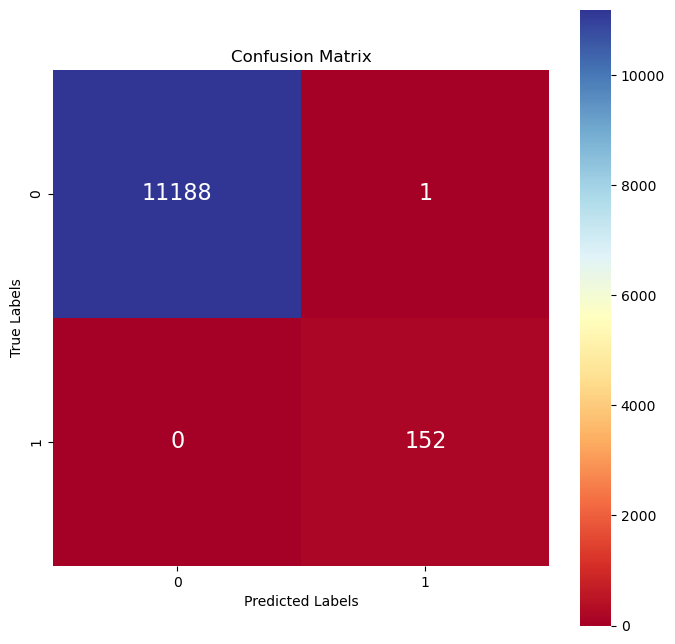

In [93]:
# Average the predictions of the ensemble classifiers
mean_preds = np.mean([np.array(model.predict(np.asarray(X).astype(np.float32))) for model in ensemble_models], axis=0)
final_score = comp_score(np.array(y), pd.DataFrame(mean_preds, columns=['prediction']), '')
final_recall = recall_metric(np.array(y), mean_preds)

print(f"pAUC of 5-fold mean predictions: {final_score} \n")
print(f"Recall of 5-fold mean predictions: {final_recall} \n")
    
fig = plot_cm(np.array(y), mean_preds)

pAUC of 5-fold mean predictions: 0.11156151692425569 

Recall of 5-fold mean predictions: 0.5921052631578947 



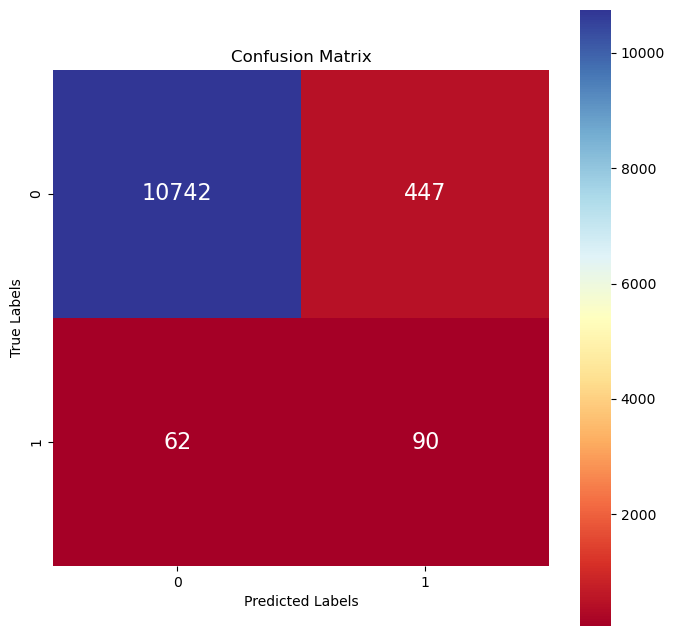

In [94]:
# Average the predictions of the TabNet classifiers
mean_preds = np.mean([np.array(model.predict(np.asarray(X).astype(np.float32))) for model in tabnet_models], axis=0)
final_score = comp_score(np.array(y), pd.DataFrame(mean_preds, columns=['prediction']), '')
final_recall = recall_metric(np.array(y), mean_preds)

print(f"pAUC of 5-fold mean predictions: {final_score} \n")
print(f"Recall of 5-fold mean predictions: {final_recall} \n")
    
fig = plot_cm(np.array(y), mean_preds)